<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [95]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import requests
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# !pip install selenium

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.1


In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [84]:
VAL_SIZE=0.2

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Импортируем данные

In [6]:
train = pd.read_csv('all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [7]:
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [9]:
# Переименуем колонки для удобства
train.rename(columns={'bodyType':'body_type','fuelType':'fuel_type','modelDate':'model_date',
                     'numberOfDoors':'number_of_doors','productionDate':'production_date',
                     'vehicleConfiguration':'vehicle_configuration','vehicleTransmission':'vehicle_transmission',
                     'engineDisplacement':'engine_displacement','enginePower':'engine_power',
                     'Комплектация':'features','Привод':'drive','Руль':'steering_wheel','Состояние':'condition',
                     'Владельцы':'owners','ПТС':'car_passport','Таможня':'customs','Владение':'ownership','model':'model_name'},
            inplace=True)

In [10]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [12]:
# Переименуем колонки
test.rename(columns={'bodyType':'body_type','complectation_dict':'features','engineDisplacement':'engine_displacement',
                     'enginePower':'engine_power','fuelType':'fuel_type','modelDate':'model_date',
                    'numberOfDoors':'number_of_doors','priceCurrency':'price_currency',
                    'productionDate':'production_date','vehicleConfiguration':'vehicle_configuration',
                     'vehicleTransmission':'vehicle_transmission','Владельцы':'owners',
                    'Владение':'ownership','ПТС':'car_passport','Привод':'drive','Руль':'steering_wheel',
                     'Состояние':'condition','Таможня':'customs'}, inplace=True)

**Сделаем небольшую предобработку теста (трейн пока не трогаем)**

**В колонке engine_power в тесте содержится строковый тип данных. Необходимо привести его к integer, убрав лишние символы. Функцию см. ниже**

In [13]:
def make_digit(string):
    i=1
    while string[i].isdigit()==True:
        i+=1
    return int(string[:i])

In [14]:
test['engine_power']=test['engine_power'].apply(make_digit)

**Аналогичным образом необходимо обработать колонку owners в тесте.**

In [15]:
test['owners']=test['owners'].apply(make_digit)

**Сразу бросается в глаза, что в тесте и в трейне - разные наборы признаков. Обучить модель на разных наборах признаков не получится. Значит, найдем пересечение этих множеств. Как видно из куска кода ниже, общих признаков 23, что вполне достаточно.**

In [16]:
train_columns=set(train.columns)
test_columns=set(test.columns)
intersection=train_columns.intersection(test_columns)
len(intersection)

23

In [17]:
# Признаки, которые есть в трейне, но нет в тесте
train_columns.difference(test_columns)

{'hidden', 'price', 'start_date'}

In [18]:
# Признаки, которые есть в тесте, но нет в трейне
test_columns.difference(train_columns)

{'car_url',
 'equipment_dict',
 'image',
 'model_info',
 'parsing_unixtime',
 'price_currency',
 'sell_id',
 'super_gen',
 'vendor'}

## Парсинг сайта auto.ru

**Дополним датасет train данными из Интернета. Для этого сначала соберем дополнительный датасет,
который объединим с train**

In [19]:
# Функция, возвращающая датасет из ссылок на машины определенной марки
def get_brand_links(brand):
    s=Service('C:\SkillFactory\chromedriver.exe')
    driver = webdriver.Chrome(service=s)
    pages = 2
    href = []
    for page in range(1, pages):
        url = "https://auto.ru/novosibirsk/cars/" + brand + "/all/?page=" + str(page)
        driver.get(url)
        items = driver.find_elements_by_xpath('//a[@class="Link ListingItemTitle__link"]')
        for i in range(len(items)):
            href.append(items[i].get_attribute('href'))
    df = pd.DataFrame(href)
# df.to_csv('links1.csv')
    driver.close()
    return df

In [20]:
# Соберем данные для марки BMW
data_bmw=get_brand_links('bmw')
data_bmw

<ipython-input-19-a4dada1900ca>:10: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  items = driver.find_elements_by_xpath('//a[@class="Link ListingItemTitle__link"]')


,0
0,https://auto.ru/cars/new/group/bmw/x7/21406262...
1,https://auto.ru/cars/used/sale/bmw/x4/11056850...
2,https://auto.ru/cars/used/sale/bmw/x3/11053384...
3,https://auto.ru/cars/used/sale/bmw/x6/11147841...
4,https://auto.ru/cars/new/group/bmw/3er/2159242...
5,https://auto.ru/cars/used/sale/bmw/x7/11053384...
6,https://auto.ru/cars/used/sale/bmw/x6/11058809...
7,https://auto.ru/cars/used/sale/bmw/x3/11147029...
8,https://auto.ru/cars/used/sale/bmw/x5/11148304...
9,https://auto.ru/cars/new/group/bmw/x7/22439407...


In [21]:
# Функиция, выполняющая переход по ссылке в датафрейме и возвращающая содержимое страницы в HTML
def get_soup(url):
    response=requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).content.decode('utf-8') 
    soup=BeautifulSoup(response,'html.parser')
    return soup

In [26]:
# Создадим колонку soup, куда запишем содержимое страниц в формате html
data_bmw['soup']=data_bmw[0].apply(get_soup)

In [27]:
# Функция, извлекающая значения четырех нужных нам признаков по определенному тегу
def get_four_features(soup):
    features=soup.find_all('a', class_='Link Link_color_black')
    features_list=[]
    for i in features:
        features_list.append(i.text)
    return features_list  

In [28]:
data_bmw['four_features']=data_bmw['soup'].apply(get_four_features)

In [30]:
# Распарсим четыре найденных признака
data_bmw['production_date']=data_bmw['four_features'].apply(lambda x: x[0] if len(x)>0 else np.nan)
data_bmw['body_type']=data_bmw['four_features'].apply(lambda x: x[1] if len(x)>0 else np.nan)
data_bmw['color']=data_bmw['four_features'].apply(lambda x: x[2] if len(x)>0 else np.nan)
data_bmw['fuel_type']=data_bmw['four_features'].apply(lambda x: x[3] if len(x)>0 else np.nan)

In [31]:
# Функция, вычисляющая количество дверей
def get_doors(x):
    if type(x)==float:
        return np.nan
    elif x.find('5')>=0:
        return 5
    else: 
        return 4

In [32]:
data_bmw['number_of_doors']=data_bmw['body_type'].apply(get_doors)

In [33]:
# Функция, извлекающая информацию о коробке передач
def get_vehicle_transmission(soup):
    features=soup.find_all('li', class_='CardInfoRow CardInfoRow_transmission')
    features_list=[]
    for i in features:
        features_list.append(i.text)
    if len(features_list)==0:
        return np.nan
    elif 'автоматическая' in features_list[0]:
        return 'автоматическая'
    elif 'роботизированная' in features_list[0]:
        return 'роботизированная'
    elif 'механическая' in features_list[0]:
        return 'механическая'
    elif 'вариатор' in features_list[0]:
        return 'вариатор'
    else: 
        return np.nan

In [34]:
data_bmw['vehicle_transmission']=data_bmw['soup'].apply(get_vehicle_transmission)

In [35]:
# Функция, извлекающая информацию о приводе
def get_drive(soup):
    features=soup.find_all('li', class_='CardInfoRow CardInfoRow_drive')
    features_list=[]
    for i in features:
        features_list.append(i.text)
    if len(features_list)==0:
        return np.nan
    elif 'передний' in features_list[0]:
        return 'передний'
    elif 'задний' in features_list[0]:
        return 'задний'
    elif 'полный' in features_list[0]:
        return 'полный'
    else: 
        return np.nan

In [36]:
data_bmw['drive']=data_bmw['soup'].apply(get_drive)

In [37]:
# Функция, извлекающая информацию о руле
def get_steering_wheel(soup):
    features=soup.find_all('li', class_='CardInfoRow CardInfoRow_wheel')
    features_list=[]
    for i in features:
        features_list.append(i.text)
    if len(features_list)==0:
        return np.nan
    elif 'Левый' in features_list[0]:
        return 'Левый'
    elif 'Правый' in features_list[0]:
        return 'Правый'
    else: 
        return np.nan

In [38]:
data_bmw['steering_wheel']=data_bmw['soup'].apply(get_steering_wheel)

In [39]:
# Функция, извлекающая количество владельцев
def get_owners(soup):
    features=soup.find_all('li', class_='CardInfoRow CardInfoRow_ownersCount')
    features_list=[]
    for i in features:
        features_list.append(i.text)
    if len(features_list)==0:
        return np.nan
    for j in range(0,len(features_list[0])):
        if features_list[0][j].isdigit()==True:
            return features_list[0][j]

In [40]:
data_bmw['owners']=data_bmw['soup'].apply(get_owners)

In [41]:
# Функция, извлекающая информацию о ПТС
def get_car_passport(soup):
    features=soup.find_all('li', class_='CardInfoRow CardInfoRow_pts')
    features_list=[]
    for i in features:
        features_list.append(i.text)
    if len(features_list)==0:
        return np.nan
    elif 'Оригинал' in features_list[0]:
        return 'Оригинал'
    elif 'Дубликат' in features_list[0]:
        return 'Дубликат'
    else: 
        return np.nan

In [42]:
data_bmw['car_passport']=data_bmw['soup'].apply(get_car_passport)

In [43]:
# Функция, извлекающая информацию о 30-ти определенных полях на странице. Нам не нужны все эти поля. Мы возьмем только некоторые
def get_thirty_features(soup):
    features=soup.find_all('span', class_='CardInfoRow__cell')
    features_list=[]
    for i in features:
        features_list.append(i.text)
    return features_list

In [44]:
data_bmw['thirty_features']=data_bmw['soup'].apply(get_thirty_features)

In [45]:
# Функция, извлекающая информацию о пробеге
def get_mileage(features):
    if len(features)==0:
        return np.nan
    if features[3][0].isdigit()==False:
        return np.nan
    i=0
    while features[3][i].isdigit()==True:
        i+=1
    return int(features[3][:i])*1000

In [46]:
data_bmw['mileage']=data_bmw['thirty_features'].apply(get_mileage)

In [47]:
# Функция, извлекающая информацию о мощности двигателя
def get_engine_power(features):
    if len(features)==0:
        return np.nan
    if features[9][0].isdigit()==False:
        return np.nan
    parts=features[9].split('/')
    power=parts[1].strip()
    i=0
    while power[i].isdigit()==True:
        i+=1
    return int(power[:i])

In [48]:
data_bmw['engine_power']=data_bmw['thirty_features'].apply(get_engine_power)

In [49]:
data_bmw.head()

,0,soup,four_features,production_date,body_type,color,fuel_type,number_of_doors,vehicle_transmission,drive,steering_wheel,owners,car_passport,thirty_features,mileage,engine_power
0,https://auto.ru/cars/new/group/bmw/x7/21406262...,"[html, [[<link as=""script"" href=""https://auto....",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN
1,https://auto.ru/cars/used/sale/bmw/x4/11056850...,"[html, [[<link as=""script"" href=""https://auto....","[2019, внедорожник 5 дв., серый, Бензин]",2019,внедорожник 5 дв.,серый,Бензин,5.0,автоматическая,полный,Левый,2,Оригинал,"[год выпуска, 2019, Пробег, 87 000 км, Кузов, ...",87000.0,184.0
2,https://auto.ru/cars/used/sale/bmw/x3/11053384...,"[html, [[<link as=""script"" href=""https://auto....","[2018, внедорожник 5 дв., белый, Дизель]",2018,внедорожник 5 дв.,белый,Дизель,5.0,автоматическая,полный,Левый,1,Оригинал,"[год выпуска, 2018, Пробег, 86 000 км, Кузов, ...",86000.0,340.0
3,https://auto.ru/cars/used/sale/bmw/x6/11147841...,"[html, [[<link as=""script"" href=""https://auto....","[2017, внедорожник 5 дв., чёрный, Дизель]",2017,внедорожник 5 дв.,чёрный,Дизель,5.0,автоматическая,полный,Левый,3,Оригинал,"[год выпуска, 2017, Пробег, 79 000 км, Кузов, ...",79000.0,313.0
4,https://auto.ru/cars/new/group/bmw/3er/2159242...,"[html, [[<link as=""script"" href=""https://auto....",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN


**К сожалению, мне не удалось понять, в каком теге находится цена на автомобиль (целевая переменная). С другими признаками такой проблемы не возникло. Для цены срабатывает некий скрипт при наведении курсора мышки. Это затрудняет определение тега, в котором находится цена. При выборе опции "Посмотреть код" для цены выводится неверная информация.**

**Таким образом, у нас нет целевой переменной по итогам парсинга. Значит, объединять датасет data_bmw (и другие датасеты для других марок) с обучающим датасетом не имеет смысла.**

## Обработка данных и feature engineering

In [50]:
# Приведем трейн и тест в одинаковый вид, чтобы их можно было объединить при помощи join.
# Обратите внимание, что я избавилась от колонки condition (Состояние) в обоих датасетах. 
# Дело в том, что в этой колонке в трейне стоят только NaN. Значит, она бесполезна для обучения модели
test['price']=0
train['sell_id']=0
train.drop(columns=['hidden','start_date','condition'], inplace=True)
test.drop(columns=['condition','car_url','equipment_dict','image','model_info','parsing_unixtime',
                  'price_currency','super_gen','vendor'], inplace=True)

In [51]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [52]:
data.columns

Index(['body_type', 'brand', 'color', 'features', 'description',
       'engine_displacement', 'engine_power', 'fuel_type', 'mileage',
       'model_date', 'model_name', 'name', 'number_of_doors',
       'production_date', 'sell_id', 'vehicle_configuration',
       'vehicle_transmission', 'owners', 'ownership', 'car_passport', 'drive',
       'steering_wheel', 'customs', 'price', 'sample'],
      dtype='object')

In [53]:
# Выделим колонки с непрерывным типом данных
numeric_columns=['model_date','number_of_doors','production_date','engine_power','mileage','owners','price']

C:\Users\Sasha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


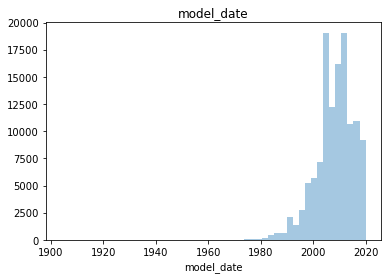

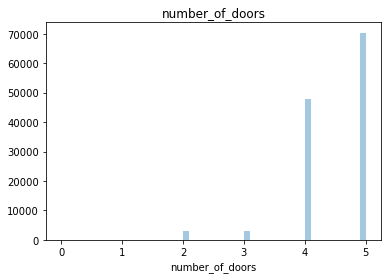

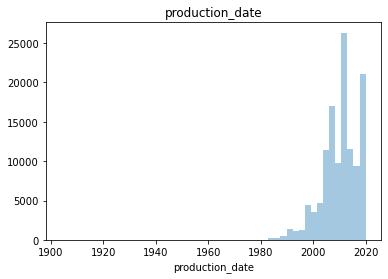

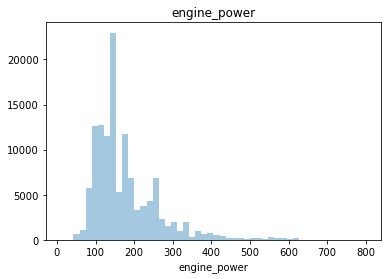

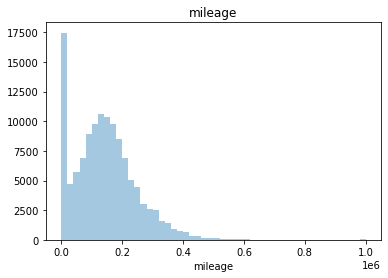

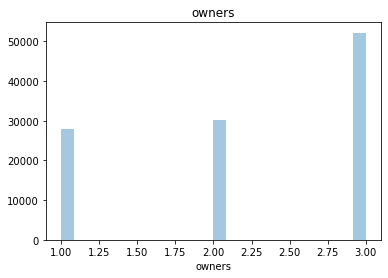

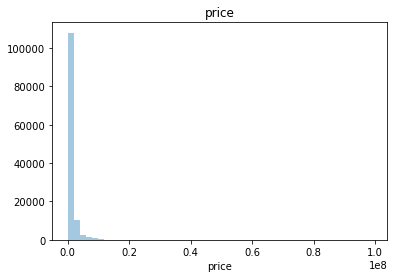

In [54]:
# Нарисуем графики непрерывных признаков
for i in numeric_columns:
    plt.figure()
    sns.distplot(data[i].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [55]:
# Попробуем прологарифмировать некоторые колонки, у которых наблюдается "хвост". Логарифмируем в том
# числе колонку price (целевая переменная). На baseline было показано, что это улучшает целевую метрику
data['model_date']=data['model_date'].apply(lambda x: np.log(x+1))
data['production_date']=data['production_date'].apply(lambda x: np.log(x+1))
data['engine_power']=data['engine_power'].apply(lambda x: np.log(x+1))
data['mileage']=data['mileage'].apply(lambda x: np.log(x+1))
data['price']=data['price'].apply(lambda x: np.log(x+1))

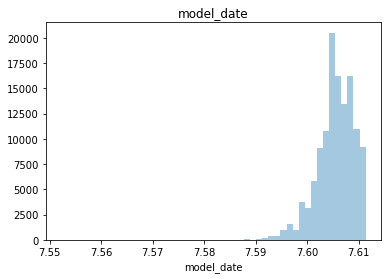

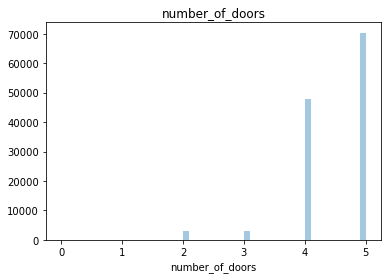

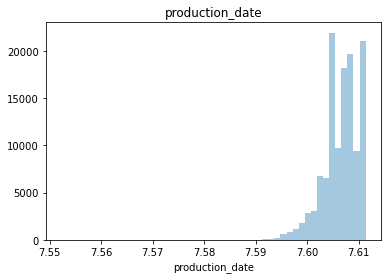

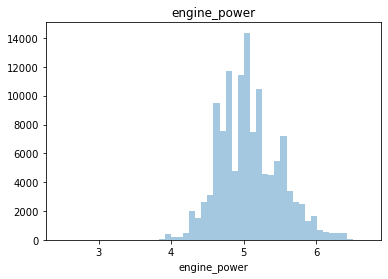

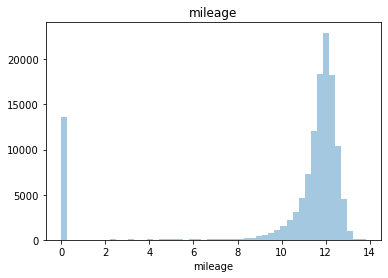

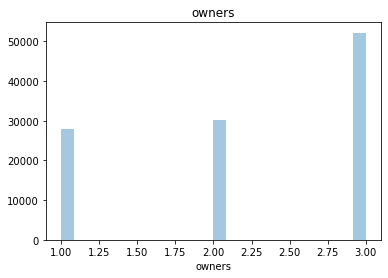

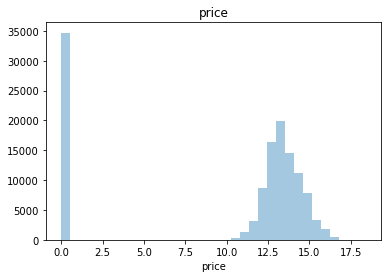

In [56]:
# Выведем признаки еще раз
for i in numeric_columns:
    plt.figure()
    sns.distplot(data[i].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

**Видно, что у нас довольно много новых машин, для которых mileage=0. Создадим специальную бинарную переменную, содержащую информацию о том, нулевой или нет у машины mileage**

In [57]:
data['is_mileage_zero']=data['mileage'].apply(lambda x: 1 if x==0 else 0)

<AxesSubplot:>

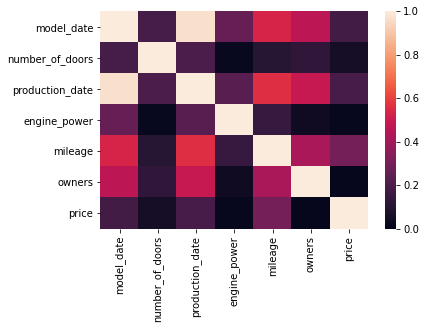

In [58]:
# Построим тепловую карту матрицы корреляций непрерывных признаков.
# Видно, что mileage скоррелирован с model_date и production_date. Это логично, т.к. больший пробег
# обычно означает более раннюю дату выпуска. Кроме того, количество владельцев также скоррелировано 
# с production_date и model_date, т.к. у более старых машин обычно больше владельцев.
sns.heatmap(data[numeric_columns].corr().abs(), vmin=0, vmax=1)

## Работа с пропусками

In [59]:
data.isna().sum()

body_type                    1
brand                        0
color                        0
features                 28268
description               3254
engine_displacement          1
engine_power                 1
fuel_type                    0
mileage                      0
model_date                   1
model_name                   0
name                         1
number_of_doors              1
production_date              0
sell_id                      0
vehicle_configuration        1
vehicle_transmission         1
owners                   13588
ownership                82868
car_passport               362
drive                        1
steering_wheel               0
customs                      0
price                      410
sample                       0
is_mileage_zero              0
dtype: int64

In [60]:
# Очень много колонок, где по одному пропуску. Эти пропуски просто удалим.
data.dropna(axis=0, subset=['body_type','engine_displacement','engine_power','model_date','name',
                            'number_of_doors','vehicle_configuration','vehicle_transmission','drive'],
           inplace=True)

**Остальные пропуски будем заполнять. Сделаем это чуть позже.**

## Работа с категориальными признаками

In [61]:
# Выпишем отдельно категориальные колонки
cat_columns=['body_type', 'brand', 'color', 'features', 'description',
       'engine_displacement', 'engine_power', 'fuel_type',
       'model_name', 'name',
       'sell_id', 'vehicle_configuration',
       'vehicle_transmission', 'ownership', 'car_passport', 'drive',
       'steering_wheel', 'customs']

In [62]:
# Выведем количество уникальных значений для категориальных колонок
for i in cat_columns:
    print("Количество уникальных значений для колонки {} равно {}".format(i,data[i].nunique()))

Количество уникальных значений для колонки body_type равно 192
Количество уникальных значений для колонки brand равно 36
Количество уникальных значений для колонки color равно 32
Количество уникальных значений для колонки features равно 8203
Количество уникальных значений для колонки description равно 100105
Количество уникальных значений для колонки engine_displacement равно 589
Количество уникальных значений для колонки engine_power равно 398
Количество уникальных значений для колонки fuel_type равно 5
Количество уникальных значений для колонки model_name равно 1104
Количество уникальных значений для колонки name равно 4774
Количество уникальных значений для колонки sell_id равно 34687
Количество уникальных значений для колонки vehicle_configuration равно 2023
Количество уникальных значений для колонки vehicle_transmission равно 8
Количество уникальных значений для колонки ownership равно 565
Количество уникальных значений для колонки car_passport равно 4
Количество уникальных значен

In [63]:
# Найдем 10 наиболее часто встречающихся body_type
most_common_body_types=Counter(data['body_type'].str.cat(sep='/').lower().split('/')).most_common(10)

In [64]:
# Соберем из списка кортежей просто список
list_of_most_common_body_types=[]
for i in most_common_body_types:
    list_of_most_common_body_types.append(i[0])
list_of_most_common_body_types

['внедорожник 5 дв.',
 'седан',
 'хэтчбек 5 дв.',
 'лифтбек',
 'универсал 5 дв.',
 'минивэн',
 'компактвэн',
 'купе',
 'хэтчбек 3 дв.',
 'седан long']

In [65]:
# Функция, которая проверяет, есть ли в данной ячейке элемент из списка list_of_most_common_body_types
def create_dummy_column(some_list):
    if col in some_list:
        return 1
    else:
        return 0  

In [66]:
# Создадаим новые признаки с помощью функции create_dummy_column - аналоги dummy-переменных
for col in list_of_most_common_body_types:
    data[col]=data['body_type'].apply(create_dummy_column)

**Аналогичным образом обработаем колонки brand, color**

In [67]:
most_common_brands=Counter(data['brand'].str.cat(sep='/').lower().split('/')).most_common(10)

list_of_most_common_brands=[]
for i in most_common_brands:
    list_of_most_common_brands.append(i[0])
list_of_most_common_brands

['mercedes',
 'bmw',
 'volkswagen',
 'nissan',
 'toyota',
 'audi',
 'mitsubishi',
 'hyundai',
 'kia',
 'skoda']

In [68]:
for col in list_of_most_common_brands:
    data[col]=data['brand'].apply(create_dummy_column)

In [69]:
# В колонке color часть цветов написана по-русски, а часть - в виде кодировки. К сожалению, не очень 
# понятно, повторяются цвета или нет. Под кодировкой имеется в виду конкретный оттенок (например,
# светло-зеленый). Но то имеется в виду просто под "зеленый"? Для простоты будем считать, что все это - 
# разные цвета.
data['color'].unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый',
       '040001', 'EE1D19', '0000CC', 'CACECB', '007F00', 'FAFBFB',
       '97948F', '22A0F8', '660099', '200204', 'C49648', 'DEA522',
       '4A2197', 'FFD600', 'FF8649', 'FFC0CB'], dtype=object)

In [70]:
# Найдем 10 наиболее часто встречающихся цветов
most_common_colors=Counter(data['color'].str.cat(sep='/').lower().split('/')).most_common(10)

list_of_most_common_colors=[]
for i in most_common_colors:
    list_of_most_common_colors.append(i[0])
list_of_most_common_colors

['040001',
 'fafbfb',
 'cacecb',
 'чёрный',
 '97948f',
 '0000cc',
 'белый',
 'ee1d19',
 'серебристый',
 'серый']

In [71]:
for col in list_of_most_common_colors:
    data[col]=data['color'].apply(create_dummy_column)

In [45]:
# Колонки fuel_type, vehicle_transmission, car_passport, drive, steering_wheel и customs я планирую 
# обработать с помощью OneHotEncoder

In [72]:
# В колонке vehicle_transmission есть повторяющаяся информация на русском и на английском. Приведем
# ее к единому виду
dict_of_transmissions={'роботизированная':'ROBOT','механическая':'MECHANICAL',
                       'автоматическая':'AUTOMATIC','вариатор':'VARIATOR'}
data['vehicle_transmission']=data['vehicle_transmission'].apply(lambda x: dict_of_transmissions[x] if
                                                               x in dict_of_transmissions.keys() else x)

In [73]:
# Аналогичная ситуация с колонкой car_passport
dict_of_car_passports={'Оригинал':'ORIGINAL','Дубликат':'DUPLICATE'}
data['car_passport']=data['car_passport'].apply(lambda x: dict_of_car_passports[x] if x in 
                                               dict_of_car_passports.keys() else x)

In [74]:
# Заполним пропуски в колонке car_passport. Заполнять будем случайными значениями из уже имеющихся
prob = data['car_passport'].value_counts(normalize=True)
ind = data[data['car_passport'].isna()==True].index
fill_list = pd.Series(random.choices(prob.index, prob, k=data['car_passport'].isna().sum()))
fill_list.index = ind
data['car_passport']=data['car_passport'].fillna(fill_list)

In [75]:
# Аналогичная ситуация с колонкой steering_wheel
dict_of_steering_wheels={'Левый':'LEFT','Правый':'RIGHT'}
data['steering_wheel']=data['steering_wheel'].apply(lambda x: dict_of_steering_wheels[x] if x in 
                                               dict_of_steering_wheels.keys() else x)

In [76]:
# В колонке customs два значения - True и Растаможен. Но это одно и то же, так как в трейне встречается 
# только True, а в тесте - только Растаможен. Получается, этот признак не несет никакой полезной 
# информации для модели. Значит, его можно удалить.
print(data['customs'].value_counts())
data.drop(columns=['customs'], inplace=True)

True          89377
Растаможен    34686
Name: customs, dtype: int64


## Подготовка данных к загрузке в модель

In [77]:
# Удалим пропуски целевой переменной
data.dropna(axis=0,subset=['price'],inplace=True)

In [78]:
data.columns

Index(['body_type', 'brand', 'color', 'features', 'description',
       'engine_displacement', 'engine_power', 'fuel_type', 'mileage',
       'model_date', 'model_name', 'name', 'number_of_doors',
       'production_date', 'sell_id', 'vehicle_configuration',
       'vehicle_transmission', 'owners', 'ownership', 'car_passport', 'drive',
       'steering_wheel', 'price', 'sample', 'is_mileage_zero',
       'внедорожник 5 дв.', 'седан', 'хэтчбек 5 дв.', 'лифтбек',
       'универсал 5 дв.', 'минивэн', 'компактвэн', 'купе', 'хэтчбек 3 дв.',
       'седан long', 'mercedes', 'bmw', 'volkswagen', 'nissan', 'toyota',
       'audi', 'mitsubishi', 'hyundai', 'kia', 'skoda', '040001', 'fafbfb',
       'cacecb', 'чёрный', '97948f', '0000cc', 'белый', 'ee1d19',
       'серебристый', 'серый'],
      dtype='object')

In [55]:
# Колонки fuel_type, vehicle_transmission, car_passport, drive, steering_wheel, number_of_doors,
# owners я планирую обработать с помощью OneHotEncoder

In [79]:
train_data=data.query('sample==1').drop(columns=['body_type','brand','color','features','description',
                                                 'engine_displacement','engine_power','model_name',
                                                'name','sell_id','vehicle_configuration','ownership',
                                                'sample','owners'], axis=1)
test_data=data.query('sample==0').drop(columns=['body_type','brand','color','features','description',
                                                 'engine_displacement','engine_power','model_name',
                                                'name','sell_id','vehicle_configuration','ownership',
                                                'sample','owners','price'], axis=1)

In [80]:
train_data_numeric=train_data[['mileage','model_date','production_date']]
test_data_numeric=test_data[['mileage','model_date','production_date']]

scaler=RobustScaler()

train_data_numeric=scaler.fit_transform(train_data_numeric)
test_data_numeric=scaler.transform(test_data_numeric)

In [81]:
columns=['fuel_type','vehicle_transmission','car_passport','drive','steering_wheel','number_of_doors']

ohe_train=OneHotEncoder(sparse=False)
X_cat_train=ohe_train.fit_transform(train_data[columns].values)

ohe_test=OneHotEncoder(sparse=False)
X_cat_test=ohe_test.fit_transform(test_data[columns].values)

In [82]:
train_data_other=train_data.drop(columns=['mileage','model_date','production_date','fuel_type',
                                          'vehicle_transmission','car_passport','drive',
                                          'steering_wheel','number_of_doors','price'], axis=1)
test_data_other=test_data.drop(columns=['mileage','model_date','production_date','fuel_type',
                                          'vehicle_transmission','car_passport','drive',
                                          'steering_wheel','number_of_doors'], axis=1)
X=np.hstack([train_data_numeric,X_cat_train,train_data_other])
X_valid=np.hstack([test_data_numeric,X_cat_test,test_data_other])

y=train_data['price']

In [85]:
# Разделим данные из трейна на трейн и тест
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [86]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape, X_valid.shape

((71173, 55), (17794, 55), (71173,), (17794,), (34686, 55))

## Обучение модели

## Градиентный бустинг

In [87]:
# Я не очень хочу использовать CatBoost. Вместо этого я буду пользоваться градиентным бустингом.
# Для начала возьмем градиентный бустинг с параметрами по умолчанию
gbr=GradientBoostingRegressor()

gbr.fit(X_train,y_train)
y_pred_test=gbr.predict(X_test)
y_pred_train=gbr.predict(X_train)

In [88]:
# Посчитаем метрики на трейне и на тесте, чтобы проверить, нет ли переобучения
print(f"Точность модели на трейне по метрике MAPE: {(mape(y_train, y_pred_train))*100:0.2f}%")
print(f"Точность модели на тесте по метрике MAPE: {(mape(y_test, y_pred_test))*100:0.2f}%")

Точность модели на трейне по метрике MAPE: 2.16%
Точность модели на тесте по метрике MAPE: 2.18%


**Метрики на трейне и на тесте практически не отличаются. Значит, переобучения градиентного бустинга нет**

**Попробуем подобрать оптимальные параметры градиентного бустинга c помощью инструмента RandomizedSearchCV**

In [94]:
# Сетка параметров
param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750],
              'max_depth':[5,6,7,8,9,10,11,12,13,14,15]}

In [96]:
# Возьмем 10 итераций, что означает 10 произвольных комбинаций параметров из сетки выше. Выберем из них оптимальную комбинацию
gbr_random = RandomizedSearchCV(estimator=gbr, param_distributions=param_grid, n_iter=10, 
                                scoring='neg_mean_absolute_percentage_error',
                                cv=3, verbose=2, random_state=42)
gbr_random.fit(X_train,y_train)

best_model=gbr_random.best_estimator_
best_parameters=best_model.get_params()
print('Лучшие параметры: ',best_parameters)

best_score=gbr_random.best_score_
print('Лучшее значение метрики: {:.4f}'.format(best_score))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.0001, max_depth=13, n_estimators=1500; total time= 7.5min
[CV] END learning_rate=0.0001, max_depth=13, n_estimators=1500; total time= 7.7min
[CV] END learning_rate=0.0001, max_depth=13, n_estimators=1500; total time= 7.9min
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=750; total time= 4.1min
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=750; total time= 4.1min
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=750; total time= 4.1min
[CV] END learning_rate=1e-05, max_depth=5, n_estimators=1500; total time= 4.2min
[CV] END learning_rate=1e-05, max_depth=5, n_estimators=1500; total time= 4.3min
[CV] END learning_rate=1e-05, max_depth=5, n_estimators=1500; total time= 4.3min
[CV] END ..learning_rate=0.1, max_depth=13, n_estimators=250; total time= 1.7min
[CV] END ..learning_rate=0.1, max_depth=13, n_estimators=250; total time= 1.8min
[CV] END ..learning_rate=0.1, max_depth=13

**Лучшие параметры: learning_rate=0.1, n_estimators=750, max_depth=10.**

In [97]:
# Обучем градиентный бустинг с найденными параметрами
gbr_optimized=GradientBoostingRegressor(n_estimators=750, learning_rate=0.1, max_depth=10)

gbr_optimized.fit(X_train,y_train)
y_pred_test=gbr_optimized.predict(X_test)
y_pred_train=gbr_optimized.predict(X_train)

In [98]:
# Посчитаем метрики на трейне и на тесте, чтобы проверить, нет ли переобучения
print(f"Точность модели на трейне по метрике MAPE: {(mape(y_train, y_pred_train))*100:0.2f}%")
print(f"Точность модели на тесте по метрике MAPE: {(mape(y_test, y_pred_test))*100:0.2f}%")

Точность модели на трейне по метрике MAPE: 1.06%
Точность модели на тесте по метрике MAPE: 1.88%


**Видно, что наблюдается небольшое переобучение. Попробуем вернуть максимальную глубину дерева к значению по умолчанию (3).**

In [99]:
gbr_not_overfit=GradientBoostingRegressor(n_estimators=750, learning_rate=0.1)

gbr_not_overfit.fit(X_train,y_train)
y_pred_test=gbr_not_overfit.predict(X_test)
y_pred_train=gbr_not_overfit.predict(X_train)

In [100]:
# Посчитаем метрики на трейне и на тесте, чтобы проверить, нет ли переобучения
print(f"Точность модели на трейне по метрике MAPE: {(mape(y_train, y_pred_train))*100:0.2f}%")
print(f"Точность модели на тесте по метрике MAPE: {(mape(y_test, y_pred_test))*100:0.2f}%")

Точность модели на трейне по метрике MAPE: 1.99%
Точность модели на тесте по метрике MAPE: 2.04%


**Как видно, нам удалось добиться более близких показателей на трейне и на тесте, т.е. практически избавиться от переобучения.**

## Случайный лес

In [90]:
# Попробую также использовать случайный лес
rfr=RandomForestRegressor()

rfr.fit(X_train,y_train)
y_pred_test=rfr.predict(X_test)
y_pred_train=rfr.predict(X_train)

In [91]:
# Посчитаем метрики на трейне и на тесте, чтобы проверить, нет ли переобучения
print(f"Точность модели на трейне по метрике MAPE: {(mape(y_train, y_pred_train))*100:0.2f}%")
print(f"Точность модели на тесте по метрике MAPE: {(mape(y_test, y_pred_test))*100:0.2f}%")

Точность модели на трейне по метрике MAPE: 0.86%
Точность модели на тесте по метрике MAPE: 1.91%


**Наблюдается переобучение случайного леса. Можно было бы с ним побороться (ограничить глубину дерева, min_samples_split, min_samples_leaf и другие параметры), но я лучше воспользуюсь градиентым бустингом.**

## Сабмишн

In [101]:
# Обучим модель градиентного бустинга на всех данных
gbr_not_overfit.fit(X,y)

# Не забудем взять экспоненту от предсказаний модели, т.к. ранее мы брали логарифм целевой переменной
predict_submission=np.exp(gbr_not_overfit.predict(X_valid))

In [102]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,8.598958e+05
1,1100549428,6.935078e+05
2,1100658222,8.226275e+05
3,1100937408,7.433942e+05
4,1101037972,5.874565e+05
5,1100912634,5.172302e+05
6,1101228730,9.615247e+05
7,1100165896,3.323539e+05
8,1100768262,1.401348e+06
9,1101218501,5.595198e+05


# Выводы

**1. С целью добиться лучшего значения метрики был проведен парсинг сайта auto.ru. К сожалению, парсинг не удалось довести до конца. Не получилось распарсить целевую переменную price. Остальные признаки распарсить удалось без каких-либо проблем.**

**2. Было произведено обучение модели на имеющимся в baseline датасете. Датасет был дополнен 30-ю признаками типа dummy-переменных. Для 6-ти категориальных признаков был использован OneHotEncoder. Некоторые непрерывные признаки были прологарифмированы (в том числе целевая переменная). Все непрерывные признаки были обработаны с помощью RobustScaler перед загрузкой в модель.**

**3. В качестве итоговой модели для обучения был выбран градиентный бустинг. Он более устойчив к переобучению, чем случайный лес.**

**4. С помощью инструмента RandomizedSearchCV были подобраны оптимальные параметры градиентного бустинга (n_estimators=750, learning_rate=0.1, max_depth=10). Однако, с данными параметрами наблюдается небольшое переобучение градиентного бустинга. С целью избавиться от переобучения максимальная глубина дерева была возравщена к значению по умолчанию (3). Это помогло избавиться от переобучения.**

**5. Итоговое значение метрики MAPE составляет 1.99% для трейна и 2.04% для теста. Близость метрик на трейне и на тесте подтверждает отсутствие переобучения.**